# Automated Entity Recognition in Colonial Records

In this notebook, we will do the following steps:
1. Read the data into memory and prepare it for processing
2. Setup and apply an automated entity recognition pipeline
3. Assess its results

Please *refer to the case study for all relevant context and a broader discussion*. Ideally, the case study should be read before using this notebook.

**Jupyter Notebooks are Web applications that can execute code and display its results**. They are sometimes called computational documents for this reason. If you want to use this notebook interactively, you will have to download the repository and configure your local Python environment. Otherwise, you can read simply here the code and results.

## Read and prepare the data

In [46]:
# basic imports and variables
import os # for manipulating files

data_folder = "data/"
file_1 = "BL_IOR_E_4_24.txt" # Letters received from the factory in Bengal, Jun 1758 - Mar 1760
file_2 = "BL_IOR_B_53.txt" # Court Minutes, 8 Apr 1714 - 5 Apr 1716

In [47]:
# read raw data into memory
work_with = file_1 # or use file_2 if you prefer

f = open(os.path.join(data_folder,work_with)).read() # f is a string

In [48]:
lines = f.splitlines() # we split the text into lines and print out the first few
lines[:20]

['BL_IOR_E_4_24_0001',
 'rene',
 'E16126',
 '',
 '',
 'BL_IOR_E_4_24_0002',
 '104.2 14 saut',
 '',
 '',
 'BL_IOR_E_4_24_0003',
 'News cour',
 '-',
 'Witle little and are de',
 'Directors her Affairs of the 26. Lag',
 'Houble United Compani',
 'of Merchants of England 2 Mr. 1. 700',
 'Sherin',
 'trading to the East Indies.',
 'May it please your Honours. 2',
 'We take this Opportunity of Writing']

We now have a list of strings containing the whole document, line by line. 
At a closer look, we note that every page is separated by the file identifier and an incremental number. We would like to use this information to create a list of pages, and remove all empty lines.

In [49]:
file_identifier = work_with.replace(".txt","")
pages = list()
new_page = ""

for n,line in enumerate(lines[1:]): # note how we start from the second line to include the first page
    if line.startswith(file_identifier):
        # append previous page to the list of pages
        pages.append(new_page.strip())
        # create a new empty page
        new_page = ""
    elif len(line) == 0 or line.startswith("No transcript for this item"): 
        # skip empty lines or pages
        continue
    else:
        # append the line to the current page
        new_page += " "+line

In [51]:
# check that the number of pages corresponds
len(pages)

466

In [25]:
# example of a single page
pages[22]

"21 To the Slouble the Court of same Directors for Affairs of the preading letter Houble United Company of Merchants of England trading to the last Indies May it please your Honors The opportunity of a tutor Ship bound directly for Europe offering Wehard embraced it to transmit you a Triplicale of the Letter Weroti under date the 26 August And to inform your House of such other Circumstances as We estance material and necessary for you to be cart acquainted with The Pitt Captain Willion 2 arrived the 12. September at Fort St George The left the Ships destined for China with his Majesty's Ships Grafton and Sunderta off the Madeiras, and steered for the Island of St Jago, but finding three large Bunch Ships at Anchor in the Harbor, Captan Willion made the best of his Way to same Augustine’s Bay in the Pfland of Madan -car - When the Pitt left that Bay, The met the London and Warren going in. We have therefore great reason to hope that all the above Ships imported safely at Madrass in Oct

We have now turned our raw dataset into a list of pages, each containing its automatically recognised text. 

You may want to take a moment to inspect several pages and compare them with the original images. You will notice that, despite a good overall quality, automated text recognition is never perfect: these will also have an impact when doing entity recognition and we should not expect perfect results for it either.

We now turn or attention to the entity recognition pipeline.

---

## Automated Entity Recognition

Automated Entity Recognition, often also called *Named Entity Recognition* or just *Entity Recognition*, is a popular step in **Natural Language Processing (NLP) pipelines**. Its goal is to find mentions of entities of interest, and their type. The most popular entity types are person, place and organisation. An NLP pipeline is usually comprised of several sequential steps, as illustrated here:  

<img src="resources/spacy_ner_pipeline.png" alt="spacy ner pipeline" />

From an input text, for example in page of our documents, an NLP pipeline has to deal with tokenisation (splitting a text into constituent parts, for example words), lemmatising (transforming a word into its base lemma), tagging (detecting the part of speech of a word), parsing (detecting the syntactic structure of a sentence), and more. Entity recognition therefore is but one possible step part of an NLP pipeline.

In what follows, we will rely on the spaCy library, a popular natural language toolkit in Python. For more details of the model we will use, see https://spacy.io/models/en. Firstly, we will load the library and trained model, we will then see an example and apply a basic AER pipeline to our documents.

In [52]:
# uncomment and execute this line only once. en_core_web_sm is a small model trained for English

#!python -m spacy download en_core_web_sm 

In [54]:
# an example spacy pipeline, this might take a while to execute
import spacy

texts = [
    "The New York Times is a newspaper based in New York.",
    "We will be able to go to Mars by 2035. Will you go?",
]

nlp = spacy.load("en_core_web_sm") # we load the pretrained model
# we configure the pipeline by removing steps we do not need
for doc in nlp.pipe(texts, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"], n_process=-1): 
    # we print out all detected entities: the results are not bad
    print([(ent.text, ent.label_) for ent in doc.ents])

[('The New York Times', 'ORG'), ('New York', 'GPE')]
[('Mars', 'LOC'), ('2035', 'DATE')]


In [55]:
# let us apply the same pipeline on our data, this might take a while to execute

entities = list()
for doc in nlp.pipe(pages, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"], n_process=-1):
    entities.extend([(ent.text, ent.label_) for ent in doc.ents])

In [56]:
len(entities) # we have found many entity mentions

12933

In [57]:
print(entities[:10])

[('104.2', 'CARDINAL'), ('26', 'CARDINAL'), ('Lag Houble United Compani', 'PERSON'), ('700', 'CARDINAL'), ('the East Indies', 'ORG'), ('Honours', 'ORG'), ('2', 'CARDINAL'), ('Dispatch for Europe', 'ORG'), ('Fort St George', 'GPE'), ('Setter', 'PERSON')]


In [58]:
# you can use this command to get an explanation of entity types
print(spacy.explain("NORP"))
print(spacy.explain("GPE"))

Nationalities or religious or political groups
Countries, cities, states


Note that we use a trained model which works with a fixed set of types. An important question when dealing with AER is **which typology to use** (i.e., set of types). Often, historical records require bespoke typologies to capture their rich contents.

---

## Results

Let us now take a look at the results we got. Firstly, we will create a *Pandas data frame* to more easily manipulate the data. Secondly, we will check which are the most frequent mentions. We will then look at entity occurrences in their original context. Lastly, we will create a visualisation to see the distribution of mentions by entity. We will conclude by discussing the limitations of these results, and how to proceed to evaluate their quality more rigorously.

In [59]:
# create a data frame
import pandas as pd

df = pd.DataFrame(entities, columns=["mention","type"])

In [60]:
df.head()

,mention,type
0,104.2,CARDINAL
1,26,CARDINAL
2,Lag Houble United Compani,PERSON
3,700,CARDINAL
4,the East Indies,ORG


In [64]:
df.shape # a data frame is like a table, it has as many rows as entity mentions and two columns

(12933, 2)

In [66]:
# let us count how many times each mention occurs
df_sorted = df.groupby(["mention","type"]).size().reset_index(name='counts').sort_values('counts', ascending=False)

In [67]:
df_sorted.head(10)

,mention,type,counts
4578,One,CARDINAL,351
782,3,CARDINAL,239
544,2,CARDINAL,190
1042,6,CARDINAL,144
27,1,CARDINAL,135
7585,two,CARDINAL,84
5304,Rupee,ORG,74
1219,9,CARDINAL,72
6627,one,CARDINAL,65
60,10,CARDINAL,64


In [69]:
# let us look at the top mentions that are not a cardinal number
df_sorted[df_sorted["type"]!="CARDINAL"].head(10)

,mention,type,counts
5304,Rupee,ORG,74
1712,Board,ORG,64
2766,Europe,LOC,63
2295,Company,ORG,50
2944,French,NORP,44
2643,Dutch,NORP,42
4430,Nabob,PERSON,40
5559,Ships,ORG,31
6492,first,ORDINAL,30
5308,Rupee One Sell,ORG,26


Given the entities, we can for example look at their occurrencies to better understand why and how they are mentioned:

In [70]:
import re # for regular expressions

target_entity = "Nabob" # what to look for
span = 50 # span of interest in number of characters
occurrences = list()

for p in pages[:20]:
    # these are the places in the page where the target entity is mentioned
    hits = [m.start() for m in re.finditer(target_entity, p)]
    for h in hits:
        l_span = h - span
        r_span = h + span
        if l_span < 0:
            l_span = 0
        if r_span >= len(p):
            r_span = len(p)-1
        occurrences.append(p[l_span:r_span])

In [71]:
occurrences

['lone been in Question, but as the Treaty with the Nabob Your Influen at the Durbar by the late Revol',
 ' The Seas Sellers s of sur us in haven ire. 5 The Nabob returned to his Capitol Yesterday and upon l',
 't of get the whole of the Treaty with the present Nabob punctually performed in case your Honours se']

This is quite interesting: "nabob" was a title used for Mugal officials or governors. It is in this sense that the title appears to be used in these records. The term later came to be associated with individuals who got very wealthy in India.

Let us now look at the distribution of detected entity types in the whole collection:

In [72]:
# we import a couple of useful visualisation libraries
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("ticks")

In [74]:
# let us count how many times each type occurs
df_sorted_types = df_sorted[["type","counts"]].groupby(["type"]).agg(sum).reset_index().sort_values('counts', ascending=False)

In [75]:
df_sorted_types

,type,counts
0,CARDINAL,3716
11,ORG,3106
13,PERSON,2912
1,DATE,980
4,GPE,638
9,NORP,309
7,LOC,242
17,WORK_OF_ART,232
14,PRODUCT,213
3,FAC,181


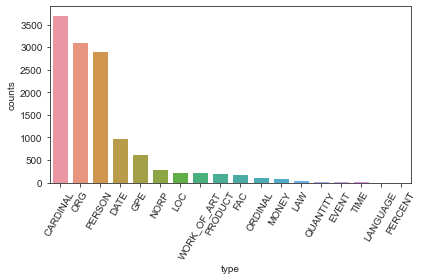

In [78]:
# we then plot this result using a bar plot
sns.barplot(df_sorted_types, x="type", y="counts")
plt.xticks(rotation=60)
plt.tight_layout()
plt.savefig("resources/type_plot.pdf")

Interestingly, we see many occurrences of numbers, organisations and persons. Why? This, we leave to you to find out.

Another good exercise is to replicate these results using other provided documents and make a comparison. Do they often mention the same entities? Is the overall distribution the same, or different? Can you suggest why?

---

## What is next

What we have seen here is the tip of the iceberg. The most promising next steps would include:
- The creation of an annotated dataset in order to evaluate AER models, and train new ones.
- Using more powerful methods, which will likely yield better results.

The evaluation of results is particularly important. Do we detect all entities correctly or not? Usually, this is done by manually annotating some documents and using them as *ground truth*. It is important to conduct a robust evaluation before using the entities for analysis or for developing new applications.

Finally, can you think of how we might use these newly detected entities for information retrieval or research?

---